In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Figure 1 (A and B)
-----

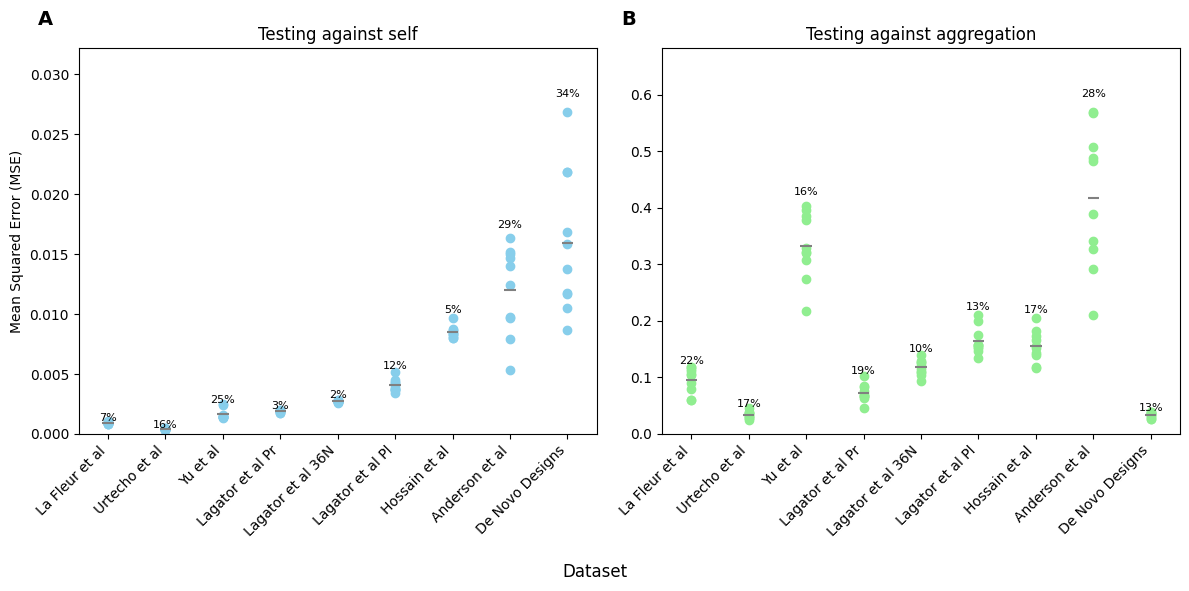

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = df['Normalized Observed log(TX/Txref)']
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# -------------------- Data Splitting Function --------------------

def split_data_by_file(df):
    file_names = df['File Name'].unique()
    split_data = {name: {} for name in file_names}
    split_data['all'] = {}

    for name in list(file_names) + ['all']:
        subset = df if name == 'all' else df[df['File Name'] == name]
        X, y = combine_columns(subset)
        X = preprocess_sequences(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        split_data[name].update({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test})

    return split_data, file_names

# -------------------- Load Evaluation Metrics --------------------

def load_repeat_evaluate(csv_path):
    df = pd.read_csv(csv_path, index_col=0)
    results = {}
    for col in df.columns:
        if ' (Self)' in col:
            key = col.replace(' (Self)', '')
            results[key] = list(zip(df[f'{key} (Self)'], df[f'{key} (All)']))
    return results

# -------------------- Main Execution --------------------

df = pd.read_csv('Data/LaFleur_supp.csv')
split_data, file_names = split_data_by_file(df)
all_results = load_repeat_evaluate('Data/repeat_evalute_each_file.csv')

file_order = [
    'La Fleur et al', 'Urtecho et al', 'Yu et al', 'Lagator et al Pr',
    'Lagator et al 36N', 'Lagator et al Pl', 'Hossain et al',
    'Anderson et al', 'De Novo Designs'
]
file_order = [f for f in file_order if f in file_names]
x = np.arange(len(file_order))

# Calculate averages and coefficient of variation (CV)
avg_results = {f: np.mean(all_results[f], axis=0) for f in file_names}
avg_train = {f: res[0] for f, res in avg_results.items()}
avg_all = {f: res[1] for f, res in avg_results.items()}

cv_train = {f: np.std([r[0] for r in all_results[f]]) / avg_train[f] for f in file_names}
cv_all = {f: np.std([r[1] for r in all_results[f]]) / avg_all[f] for f in file_names}

# Extract MSEs
train_mse = {f: [r[0] for r in all_results[f]] for f in file_order}
all_mse = {f: [r[1] for r in all_results[f]] for f in file_order}
avg_train_list = [avg_train[f] for f in file_order]
avg_all_list = [avg_all[f] for f in file_order]

# -------------------- Plotting --------------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for i, file in enumerate(file_order):
    ax1.scatter([x[i]] * len(train_mse[file]), train_mse[file], color='skyblue')
    ax1.hlines(avg_train_list[i], x[i] - 0.1, x[i] + 0.1, colors='grey')
    ax1.text(x[i], max(train_mse[file]) * 1.05, f'{int(cv_train[file]*100)}%', ha='center', fontsize=8)

ax1.set_xticks(x, file_order, rotation=45, ha='right')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.set_title('Testing against self')
ax1.set_ylim(0, max(map(max, train_mse.values())) * 1.2)

ax1.text(-0.05, 1.1, "A", transform=ax1.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

for i, file in enumerate(file_order):
    ax2.scatter([x[i]] * len(all_mse[file]), all_mse[file], color='lightgreen')
    ax2.hlines(avg_all_list[i], x[i] - 0.1, x[i] + 0.1, colors='grey')
    ax2.text(x[i], max(all_mse[file]) * 1.05, f'{int(cv_all[file]*100)}%', ha='center', fontsize=8)

ax2.set_xticks(x, file_order, rotation=45, ha='right')
ax2.set_title('Testing against aggregation')
ax2.set_ylim(0, max(map(max, all_mse.values())) * 1.2)

ax2.text(-0.05, 1.1, "B", transform=ax2.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

fig.supxlabel("Dataset")
plt.tight_layout()
plt.show()

### Figure S1
-----

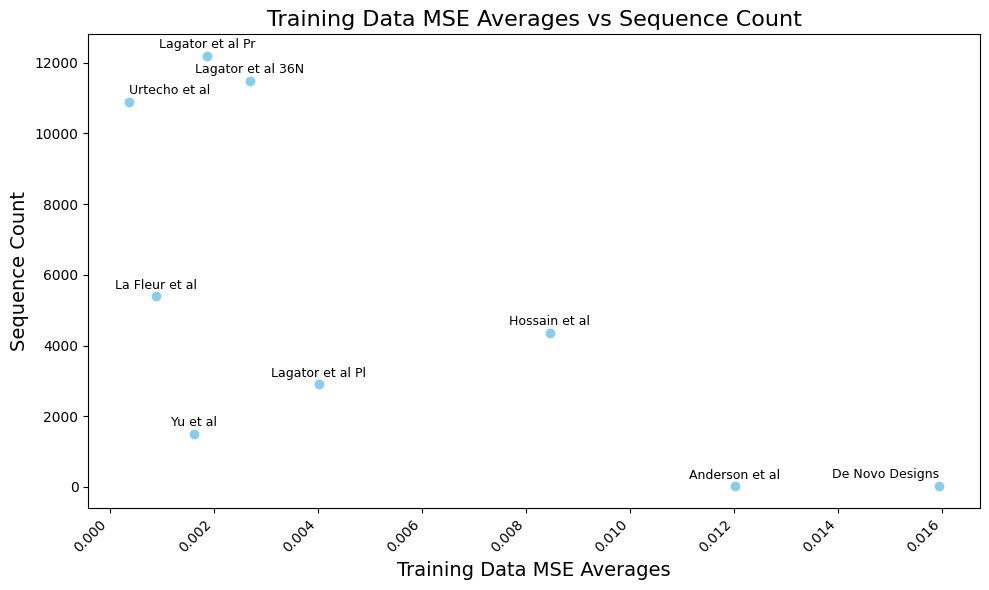

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------- Scatterplot Function --------------------

def _dynamic_text_labels(x_pos, y_pos, x_min, x_max, y_min, y_max):
    if x_pos < x_min + (x_max - x_min) * 0.05:
        ha = 'left'
    elif x_pos > x_max - (x_max - x_min) * 0.05:
        ha = 'right'
    else:
        ha = 'center'
    if y_pos < y_min + (y_max - y_min) * 0.05:
        va = 'bottom'
    elif y_pos > y_max - (y_max - y_min) * 0.05:
        va = 'top'
    else:
        va = 'center'
    return ha, va

def _adjust_text_positions(texts, offsets, x_min, x_max, y_min, y_max):
    for i, (text, offset) in enumerate(zip(texts, offsets)):
        while any(
            text.get_window_extent().overlaps(other.get_window_extent())
            for j, other in enumerate(texts)
            if i != j
        ):
            # Find the x-coordinates of the current and other texts
            text_x = text.get_position()[0]
            other_xs = [
                other.get_position()[0]
                for j, other in enumerate(texts)
                if i != j and text.get_window_extent().overlaps(other.get_window_extent())
            ]

            # Adjust position to resolve overlap
            if text_x < min(other_xs, default=x_max):
                offset[0] -= (x_max - x_min) * 0.005  # Move left
            elif text_x > max(other_xs, default=x_min):
                offset[0] += (x_max - x_min) * 0.005  # Move right
            text.set_position((offset[0], text.get_position()[1]))

# -------------------- Plotting --------------------

df = pd.read_csv('Data/CNN_file_metrics.csv')

plt.figure(figsize=(10, 6))

# Plot the scatter before adding the labels
for i, row in df.iterrows():
    plt.scatter(row['Training Data MSE Averages'], row['Sequence Count'], color='skyblue')

# Find the limits of the plot
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
y_offset = (y_max - y_min) * 0.01

# Add the labels to the scatter plot
texts = []
offsets = []
for i, row in df.iterrows():
    x_pos = row['Training Data MSE Averages']
    y_pos = row['Sequence Count'] + y_offset
    label = str(row['File Name'])
    ha, _ = _dynamic_text_labels(x_pos, y_pos, x_min, x_max, y_min, y_max)
    if any(value < 0 for value in df['Sequence Count']):
        va='top'
    else:
        va='bottom'
    text = plt.text(x_pos, y_pos, label, fontsize=9, ha=ha, va=va)
    texts.append(text)
    offsets.append([x_pos, y_pos])

# Adjust text positions to avoid overlap
_adjust_text_positions(texts, offsets, x_min, x_max, y_min, y_max)

plt.title('Training Data MSE Averages vs Sequence Count', fontsize=16)
plt.xlabel('Training Data MSE Averages', fontsize=14)
plt.ylabel('Sequence Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Figure S2
-----

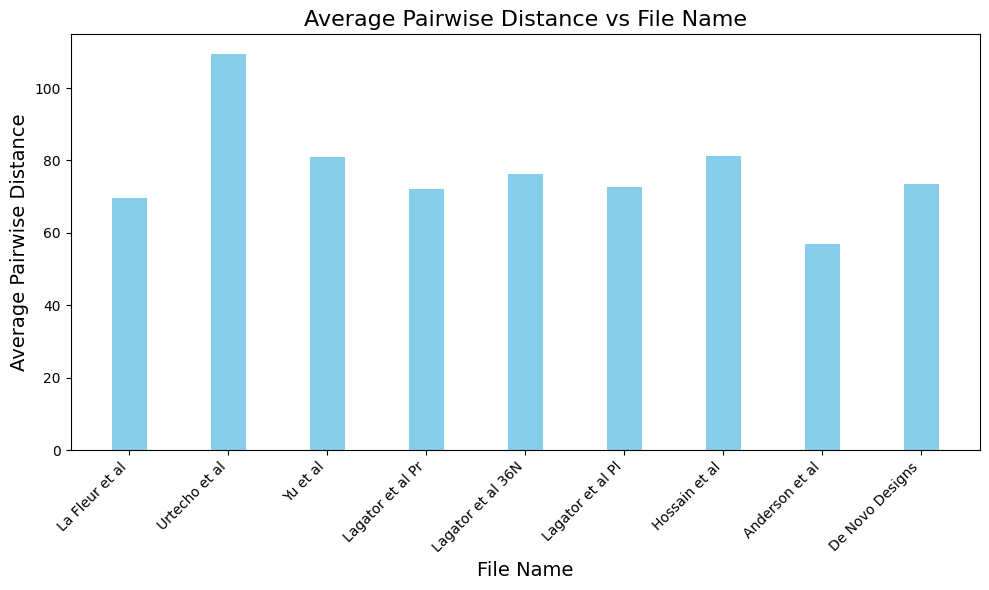

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split

# -------------------- Combine and Preprocess --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = df['Normalized Observed log(TX/Txref)']
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# -------------------- Data Splitting Function --------------------

def split_data_by_file(df):
    file_names = df['File Name'].unique()
    split_data = {name: {} for name in file_names}
    split_data['all'] = {}

    for name in list(file_names) + ['all']:
        subset = df if name == 'all' else df[df['File Name'] == name]
        X, y = combine_columns(subset)
        X = preprocess_sequences(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        split_data[name].update({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test})

    return split_data, file_names

# -------------------- Distance Calculations --------------------

def hamming_distance(seq1, seq2):
    min_len = min(len(seq1), len(seq2))
    return sum(a != b for a, b in zip(seq1[:min_len], seq2[:min_len])) + abs(len(seq1) - len(seq2))

def _average_pairwise_distance(sequences):
    distances = []
    for seq1, seq2 in combinations(sequences, 2):
        distances.append(hamming_distance(seq1, seq2))
    return np.mean(distances) if distances else 0

# -------------------- Pairwise File Distance --------------------

def get_pairwise_file_distance(df, n=10, order=None, exclude_self=False):
    if order is not None:
        df = df[df['File Name'].isin(order)]
        file_names = order
    else:
        file_names = df['File Name'].unique()
    heatmap_data = np.zeros((len(file_names), len(file_names)))

    for i, file1 in enumerate(file_names):
        seqs_file1 = df[df['File Name'] == file1]['Promoter Sequence'].sample(n=min(n, len(df[df['File Name'] == file1]))).tolist()
        for j, file2 in enumerate(file_names):
            if i > j:
                continue
            if exclude_self and i == j:
                continue
            seqs_file2 = df[df['File Name'] == file2]['Promoter Sequence'].sample(n=min(n, len(df[df['File Name'] == file2]))).tolist()
            combined_seqs = seqs_file1 + seqs_file2
            avg_hamming = _average_pairwise_distance(combined_seqs)
            heatmap_data[i, j] = avg_hamming
            heatmap_data[j, i] = avg_hamming

    return pd.DataFrame(heatmap_data, index=file_names, columns=file_names)

# --------------------  Load Eval Function -------------------

def load_repeat_evaluate(csv_path):
    df = pd.read_csv(csv_path, index_col=0)
    results = {}
    for col in df.columns:
        if ' (Self)' in col:
            key = col.replace(' (Self)', '')
            results[key] = list(zip(df[f'{key} (Self)'], df[f'{key} (All)']))
    return results

# -------------------- Bar Chart Plotting --------------------

def plot_barchart(df):
    plt.figure(figsize=(10, 6))
    plt.bar(df['File Name'], df['Average Pairwise Distance'], color='skyblue', width=0.35)
    plt.title('Average Pairwise Distance vs File Name', fontsize=16)
    plt.xlabel('File Name', fontsize=14)
    plt.ylabel('Average Pairwise Distance', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# -------------------- Main Script --------------------

df = pd.read_csv('Data/LaFleur_supp.csv')
split_data, file_names = split_data_by_file(df)
all_results = load_repeat_evaluate('Data/repeat_evalute_each_file.csv')

file_order = [
    'La Fleur et al', 'Urtecho et al', 'Yu et al', 'Lagator et al Pr',
    'Lagator et al 36N', 'Lagator et al Pl', 'Hossain et al',
    'Anderson et al', 'De Novo Designs'
]
file_order = [f for f in file_order if f in file_names]

pairwise_file_distance_df = get_pairwise_file_distance(df, order=file_order, n=100)
average_pairwise_distances = {
    file: pairwise_file_distance_df[file].sum() / (len(pairwise_file_distance_df) - 1)
    for file in pairwise_file_distance_df.columns
}

metrics_df = pd.DataFrame({
    'File Name': list(average_pairwise_distances.keys()),
    'Average Pairwise Distance': list(average_pairwise_distances.values())
})

plot_barchart(metrics_df)


### Figure S2B
-----

(Isn't Finished)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = df['Normalized Observed log(TX/Txref)']
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# -------------------- Data Splitting Function --------------------

def split_data_by_file(df):
    file_names = df['File Name'].unique()
    split_data = {name: {} for name in file_names}
    split_data['all'] = {}

    for name in list(file_names) + ['all']:
        subset = df if name == 'all' else df[df['File Name'] == name]
        X, y = combine_columns(subset)
        X = preprocess_sequences(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        split_data[name].update({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test})

    return split_data, file_names

def get_inter_file_entropy(df, normalize=True):
    return df.groupby('File Name').apply(lambda x: _calculate_average_entropy(x, normalize)).to_dict()

def _calculate_average_entropy(df, normalize):
    df['Promoter Sequence'] = df['Promoter Sequence'].apply(lambda x: x.upper())

    # Pad the sequences if necessary
    max_length = max(df['Promoter Sequence'].apply(lambda x: len(x)))
    if len(df['Promoter Sequence'].apply(lambda x: len(x)).unique()) > 1:
        df['Promoter Sequence'] = df['Promoter Sequence'].apply(lambda x: x.zfill(max_length))

    entropies = []
    for index in range(max_length):
        frequency = {'A': 0, 'C': 0, 'G': 0, 'T': 0, '0': 0}
        for sequence in df['Promoter Sequence']:
            frequency[sequence[index]] += 1
        total_count = sum(frequency.values())
        probabilities = [freq / total_count for freq in frequency.values() if freq > 0]
        entropy = -sum(p * np.log2(p) for p in probabilities)
        entropies.append(entropy)

    entropy = sum(entropies)
    if normalize:
        entropy /= max_length

    return entropy

inter_file_entropy = get_inter_file_entropy(df, normalize=True)
metrics_df['Inter-File Entropy'] = add_to_df(metrics_df, inter_file_entropy)

plot_barchart(metrics_df, 'Inter-File Entropy')

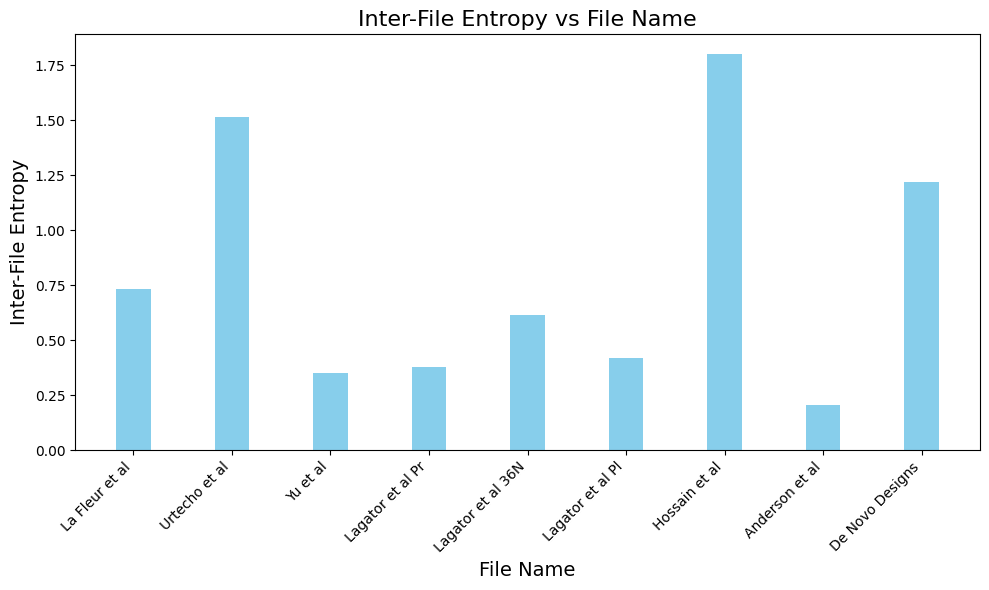

In [6]:
import pandas as pd

metrics_df = pd.read_csv('Data/CNN_file_metrics.csv')
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['File Name'], metrics_df['Inter-File Entropy'], color='skyblue', width=0.35)
plt.title('Inter-File Entropy vs File Name', fontsize=16)
plt.xlabel('File Name', fontsize=14)
plt.ylabel('Inter-File Entropy', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Figure S3
-----

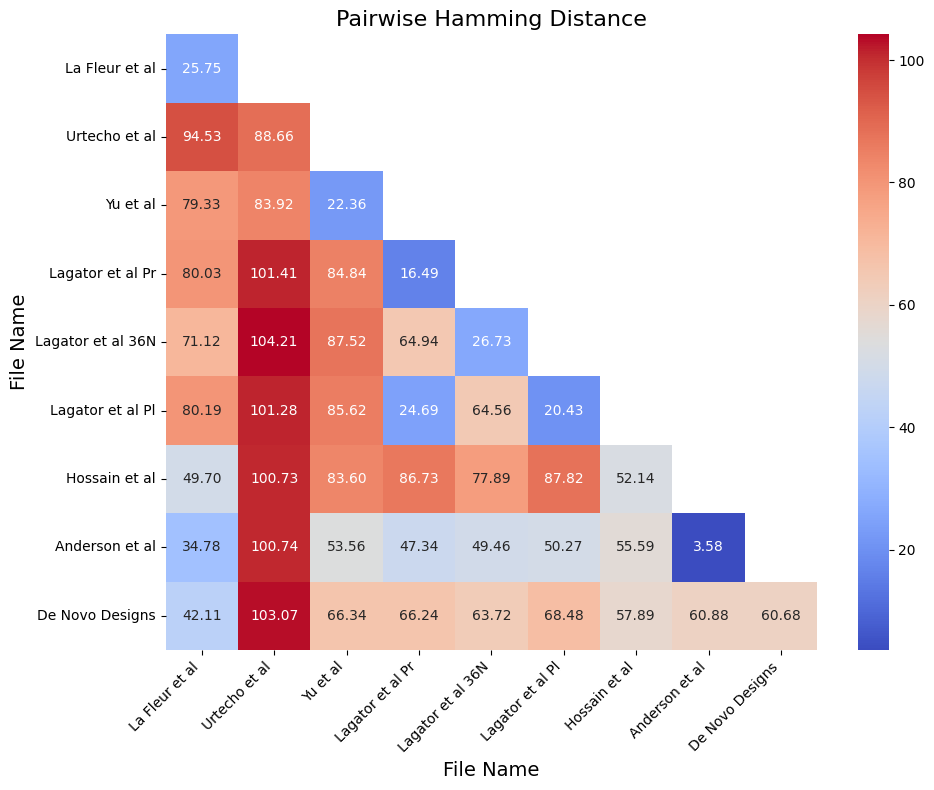

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# -------------------- Distance Calculations --------------------

def hamming_distance(seq1, seq2):
    min_len = min(len(seq1), len(seq2))
    return sum(a != b for a, b in zip(seq1[:min_len], seq2[:min_len])) + abs(len(seq1) - len(seq2))

def average_pairwise_distance(sequences):
    if len(sequences) < 2:
        return 0
    distances = [hamming_distance(s1, s2) for s1, s2 in combinations(sequences, 2)]
    return np.mean(distances)

# -------------------- Data Splitting Function --------------------

def split_data_by_file(df):
    file_names = df['File Name'].unique()
    split_data = {name: {} for name in file_names}
    split_data['all'] = {}

    for name in list(file_names) + ['all']:
        subset = df if name == 'all' else df[df['File Name'] == name]
        X, y = combine_columns(subset)
        X = preprocess_sequences(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        split_data[name].update({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test})

    return split_data, file_names

# -------------------- Pairwise Distance Matrix --------------------

def compute_pairwise_distances(df, n=10, order=None, exclude_self=False):
    file_names = order if order else df['File Name'].unique()
    dist_matrix = np.zeros((len(file_names), len(file_names)))

    for i, f1 in enumerate(file_names):
        seqs1 = df[df['File Name'] == f1]['Promoter Sequence'].sample(n=min(n, len(df[df['File Name'] == f1]))).tolist()
        for j, f2 in enumerate(file_names):
            if i > j or (exclude_self and i == j):
                continue
            seqs2 = df[df['File Name'] == f2]['Promoter Sequence'].sample(n=min(n, len(df[df['File Name'] == f2]))).tolist()
            avg_dist = average_pairwise_distance(seqs1 + seqs2)
            dist_matrix[i, j] = dist_matrix[j, i] = avg_dist

    return pd.DataFrame(dist_matrix, index=file_names, columns=file_names)


# ---------------- Usage / Heatmap Plot ----------------

df = pd.read_csv('Data/LaFleur_supp.csv')
split_data, file_names = split_data_by_file(df)
file_order = [
    'La Fleur et al', 'Urtecho et al', 'Yu et al', 'Lagator et al Pr',
    'Lagator et al 36N', 'Lagator et al Pl', 'Hossain et al',
    'Anderson et al', 'De Novo Designs'
]
file_order = [f for f in file_order if f in file_names]
pairwise_distances = compute_pairwise_distances(df, order=file_order, n=100)

mask = np.triu(np.ones(pairwise_distances.shape), k=1)
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_distances, cmap='coolwarm', annot=True, fmt=".2f", mask=mask)
plt.title('Pairwise Hamming Distance', fontsize=16)
plt.xlabel('File Name', fontsize=14)
plt.ylabel('File Name', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
